# Final Project of Big Data Framework: Flight Delay Prediction


In [21]:
# Import necessary libraries
import numpy as np  # For numerical operations
import pandas as pd  # For data manipulation and analysis
import os  # For interacting with the operating system
import pyspark  # For working with Spark
from pyspark.sql import SparkSession  # For initializing SparkSession
from pyspark.sql.types import StructType, StructField, IntegerType, StringType  # For defining schema types
from pyspark.sql.functions import col, isnan, when, count  # For data manipulation in Spark DataFrame
import pyspark.sql.functions as F  # Alias for commonly used functions in Spark DataFrame
from pyspark.ml import Pipeline  # For constructing ML pipelines
from pyspark.sql.functions import round  # For rounding values in Spark DataFrame
from pyspark.ml.feature import StringIndexer  # For converting categorical columns to numerical
from pyspark.ml.feature import VectorAssembler  # For assembling features into a vector column
from pyspark.ml.classification import DecisionTreeClassifier, LogisticRegression  # For classification models
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator  # For model evaluation


In [22]:
# Import findspark library to locate Spark in the system
import findspark
# Initialize findspark to set up the required environment variables
findspark.init()



In [23]:
# Import the PySpark module
from pyspark.sql import SparkSession

# Create SparkSession object
spark = SparkSession.builder \
                    .master('local[*]') \
                    .appName('flights') \
                    .getOrCreate()

# What version of Spark?
print(spark.version)  # Print the version of Spark

3.4.1


After encountering Hadoop errors while attempting outlier removal and showing the correlation of features in Spark, we opted to use Pandas for this task. Once outliers were successfully removed using Pandas, we saved the preprocessed data to a file named 'preprocessed_dataset'

In [4]:
# Read data from CSV file
flights = spark.read.csv('preprocessed_dataset.csv',  # Path to the CSV file
                         sep=',',  # Separator used in the CSV file
                         header=True,  # Treats the first row as header
                         inferSchema=True,  # Infers the data types of columns automatically
                         nullValue='NA')  # Specifies the null value representation in the CSV file

# Get number of records
print("The data contain %d records." % flights.count())  # Print the number of records in the DataFrame

# View the first five records
flights.show(5)  # Show the first five records in the DataFrame

# Check column data types
flights.dtypes  # Display the data types of each column in the DataFrame


The data contain 206019 records.
+---+---+---+-------+------+---+----+------+--------+-----+
|mon|dom|dow|carrier|flight|org|mile|depart|duration|delay|
+---+---+---+-------+------+---+----+------+--------+-----+
| 10| 10|  1|     OO|  5836|ORD| 157|  8.18|      51| 27.0|
| 11| 22|  1|     OO|  6016|ORD| 738|  7.17|     127|-19.0|
|  5| 25|  3|     WN|  1675|SJC| 386| 12.92|      85| 22.0|
|  3| 28|  1|     B6|   377|LGA|1076| 13.33|     182| 70.0|
|  5| 28|  6|     B6|   904|ORD| 740|  9.58|     130| 47.0|
+---+---+---+-------+------+---+----+------+--------+-----+
only showing top 5 rows



[('mon', 'int'),
 ('dom', 'int'),
 ('dow', 'int'),
 ('carrier', 'string'),
 ('flight', 'int'),
 ('org', 'string'),
 ('mile', 'int'),
 ('depart', 'double'),
 ('duration', 'int'),
 ('delay', 'double')]

# Data Preprocessing 

In [5]:
# Renaming columns
flights= flights.withColumnRenamed('mon', 'month') \
       .withColumnRenamed('dom', 'day_of_month') \
       .withColumnRenamed('dow', 'day_of_week') \
       .withColumnRenamed('carrier', 'carrier_code') \
       .withColumnRenamed('mile', 'distance') \
       .withColumnRenamed('depart', 'departure_time') \
       .withColumnRenamed('duration', 'expected_duration') \
       .withColumnRenamed('delay', 'delay_minutes')

# Show DataFrame
flights.show()

+-----+------------+-----------+------------+------+---+--------+--------------+-----------------+-------------+
|month|day_of_month|day_of_week|carrier_code|flight|org|distance|departure_time|expected_duration|delay_minutes|
+-----+------------+-----------+------------+------+---+--------+--------------+-----------------+-------------+
|   10|          10|          1|          OO|  5836|ORD|     157|          8.18|               51|         27.0|
|   11|          22|          1|          OO|  6016|ORD|     738|          7.17|              127|        -19.0|
|    5|          25|          3|          WN|  1675|SJC|     386|         12.92|               85|         22.0|
|    3|          28|          1|          B6|   377|LGA|    1076|         13.33|              182|         70.0|
|    5|          28|          6|          B6|   904|ORD|     740|          9.58|              130|         47.0|
|    8|           5|          5|          US|  2175|LGA|     214|          13.0|               7

In [6]:
# Print the schema of the DataFrame
print(flights.schema)

StructType([StructField('month', IntegerType(), True), StructField('day_of_month', IntegerType(), True), StructField('day_of_week', IntegerType(), True), StructField('carrier_code', StringType(), True), StructField('flight', IntegerType(), True), StructField('org', StringType(), True), StructField('distance', IntegerType(), True), StructField('departure_time', DoubleType(), True), StructField('expected_duration', IntegerType(), True), StructField('delay_minutes', DoubleType(), True)])


In [7]:
# Remove the 'flight' column
flights_drop_column = flights.drop('flight')  # Drops the 'flight' column from the DataFrame

# Number of records with missing 'delay' values
flights_drop_column.filter('delay IS NULL').count()  # Counts the number of records with missing 'delay' values

# Remove records with missing 'delay' values
flights_valid_delay = flights_drop_column.filter('delay IS NOT NULL')  # Filters out records with missing 'delay' values

# Remove records with missing values in any column and get the number of remaining rows
flights_clean = flights_valid_delay.dropna()  # Drops records with any missing values
print(flights_clean.count())  # Prints the number of remaining rows after removing records with missing values


206019


In [8]:
# Import the required function
from pyspark.sql.functions import round

# Convert 'mile' to 'km' and drop 'mile' column
flights_km = flights_clean.withColumn('km', round(flights_clean.distance * 1.60934, 0)) \
                    .drop('mile')

# Create 'label' column indicating whether flight delayed (1) or not (0)
flights_km = flights_km.withColumn('label', (flights_km.delay_minutes >= 15).cast('integer'))

# Check first five records
flights_km.show(5)
flights_km.count()


+-----+------------+-----------+------------+---+--------+--------------+-----------------+-------------+------+-----+
|month|day_of_month|day_of_week|carrier_code|org|distance|departure_time|expected_duration|delay_minutes|    km|label|
+-----+------------+-----------+------------+---+--------+--------------+-----------------+-------------+------+-----+
|   10|          10|          1|          OO|ORD|     157|          8.18|               51|         27.0| 253.0|    1|
|   11|          22|          1|          OO|ORD|     738|          7.17|              127|        -19.0|1188.0|    0|
|    5|          25|          3|          WN|SJC|     386|         12.92|               85|         22.0| 621.0|    1|
|    3|          28|          1|          B6|LGA|    1076|         13.33|              182|         70.0|1732.0|    1|
|    5|          28|          6|          B6|ORD|     740|          9.58|              130|         47.0|1191.0|    1|
+-----+------------+-----------+------------+---

206019

In [9]:
# Create an indexer, which identifies categories and then creates a new column with numeric index values
flights_indexed = StringIndexer(inputCol='carrier_code', outputCol='carrier_index').fit(flights_km).transform(flights_km)

# Repeat the process for org column
flights_indexed = StringIndexer(inputCol='org', outputCol='org_index').fit(flights_indexed).transform(flights_indexed)
flights_indexed.show(5)

+-----+------------+-----------+------------+---+--------+--------------+-----------------+-------------+------+-----+-------------+---------+
|month|day_of_month|day_of_week|carrier_code|org|distance|departure_time|expected_duration|delay_minutes|    km|label|carrier_index|org_index|
+-----+------------+-----------+------------+---+--------+--------------+-----------------+-------------+------+-----+-------------+---------+
|   10|          10|          1|          OO|ORD|     157|          8.18|               51|         27.0| 253.0|    1|          3.0|      0.0|
|   11|          22|          1|          OO|ORD|     738|          7.17|              127|        -19.0|1188.0|    0|          3.0|      0.0|
|    5|          25|          3|          WN|SJC|     386|         12.92|               85|         22.0| 621.0|    1|          2.0|      5.0|
|    3|          28|          1|          B6|LGA|    1076|         13.33|              182|         70.0|1732.0|    1|          4.0|      3.0|

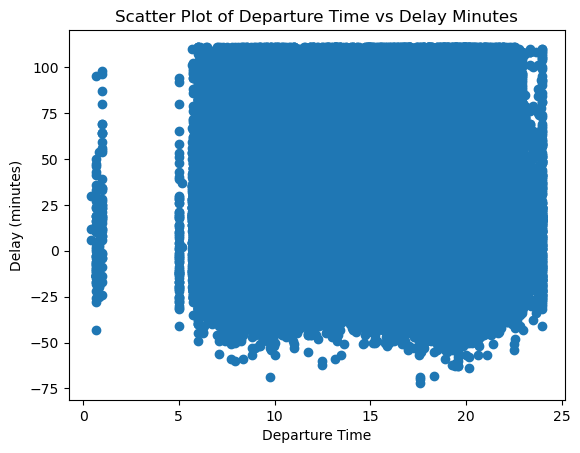

In [10]:
# Data Visualization
import matplotlib.pyplot as plt  # Import matplotlib for plotting

# Histogram of delay_minutes
# Scatter plot of departure_time vs delay_minutes

# Collect departure_time and delay_minutes data
departure_delay = flights_indexed.select('departure_time', 'delay_minutes').rdd.collect()
departure_time, delay_minutes = zip(*departure_delay)

# Create scatter plot
plt.scatter(departure_time, delay_minutes)  # Plot departure_time vs delay_minutes
plt.xlabel('Departure Time')  # Set x-axis label
plt.ylabel('Delay (minutes)')  # Set y-axis label
plt.title('Scatter Plot of Departure Time vs Delay Minutes')  # Set plot title
plt.show()  # Show the plot

The scatter plot is titled “Scatter Plot of Departure Time vs Delay Minutes.”
The horizontal axis (x-axis) represents “Departure Time,” ranging from 0 to 25.
The vertical axis (y-axis) represents “Delay (minutes),” with values ranging from approximately -75 to 100.
The plot contains a dense cluster of data points near the bottom, indicating that most departures experience little to no delay.
Some isolated data points are scattered across the vertical range, suggesting varied delay times.
Overall, the distribution implies that while most departures occur with minimal delay, there are instances where delays can be significant.


# Splitting the Dataset into Train and test

In [19]:
# Assuming that df is your DataFrame

# Split the DataFrame into training and test sets
train_df, test_df = flights_indexed.randomSplit([0.8, 0.2], seed=42)

# Print the counts of records in the training and test datasets
print(f"Training Dataset Count: {train_df.count()}")  # Print the count of records in the training dataset
print(f"Test Dataset Count: {test_df.count()}")  # Print the count of records in the test dataset

Training Dataset Count: 164828
Test Dataset Count: 41191


In [12]:
# Create an assembler object
assembler = VectorAssembler(inputCols=['month', 'day_of_month', 'day_of_week', 'carrier_index', 'org_index', 'distance', 'departure_time', 'expected_duration'], outputCol='features')

# Consolidate predictor columns
flights_assembled_train = assembler.transform(train_df)

# Check the resulting column
flights_assembled_train.select('features', 'delay_minutes').show(5, truncate=False)


+---------------------------------------+-------------+
|features                               |delay_minutes|
+---------------------------------------+-------------+
|[0.0,1.0,2.0,1.0,2.0,740.0,15.75,175.0]|17.0         |
|[0.0,1.0,2.0,1.0,2.0,944.0,15.75,185.0]|16.0         |
|[0.0,1.0,2.0,1.0,2.0,1597.0,6.58,230.0]|50.0         |
|[0.0,1.0,2.0,1.0,2.0,1597.0,13.5,225.0]|1.0          |
|[0.0,1.0,2.0,1.0,3.0,733.0,10.58,165.0]|-22.0        |
+---------------------------------------+-------------+
only showing top 5 rows



In [13]:
# Create an assembler object to assemble predictor columns into a single feature vector column
assembler = VectorAssembler(inputCols=['month', 'day_of_month', 'day_of_week', 'carrier_index', 'org_index', 'distance', 'departure_time', 'expected_duration'],
                            outputCol='features')  # Define the input and output columns for the assembler

# Consolidate predictor columns into a feature vector column
flights_assembled_test = assembler.transform(test_df)  # Apply the assembler to the test dataset

# Check the resulting columns, including the newly created 'features' column and the 'delay_minutes' column
flights_assembled_test.select('features', 'delay_minutes').show(5, truncate=False)  # Display the first 5 rows of the 'features' and 'delay_minutes' columns



+----------------------------------------+-------------+
|features                                |delay_minutes|
+----------------------------------------+-------------+
|[0.0,1.0,2.0,1.0,2.0,1391.0,14.92,245.0]|6.0          |
|[0.0,1.0,2.0,1.0,3.0,733.0,14.58,165.0] |-4.0         |
|[0.0,1.0,2.0,1.0,3.0,733.0,20.0,150.0]  |64.0         |
|[0.0,1.0,2.0,1.0,3.0,1097.0,10.67,195.0]|13.0         |
|[0.0,1.0,2.0,1.0,3.0,1389.0,6.0,240.0]  |45.0         |
+----------------------------------------+-------------+
only showing top 5 rows



# Model Selection & Evaluation

When predicting flight delays we are typically dealing with regression problems, where we aim to
predict a continuous outcome, such as the duration of delay in minutes. Linear regression
and random forest regression are two commonly used models for regression tasks in this context. 

In [14]:
from pyspark.ml.regression import LinearRegression  # Import LinearRegression from PySpark ML
from pyspark.ml.evaluation import RegressionEvaluator  # Import RegressionEvaluator from PySpark ML

# Create a LinearRegression model specifying the features column as 'features' and the label column as 'label'
lr = LinearRegression(featuresCol="features", labelCol="label")

# Train the LinearRegression model using the training data
lr_model = lr.fit(flights_assembled_train)  # Fit the model to the training data

# Use the trained model to make predictions on the test data
predictions = lr_model.transform(flights_assembled_test)  # Make predictions on the test data


In [15]:
# Instantiate the evaluator for regression, specifying the prediction column and the label column
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label")

# Calculate Mean Squared Error (MSE)
mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})  # Evaluate MSE
print("Mean Squared Error (MSE):", mse)  # Print MSE

# Calculate Mean Absolute Error (MAE)
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})  # Evaluate MAE
print("Mean Absolute Error (MAE):", mae)  # Print MAE

# Calculate Root Mean Squared Error (RMSE)
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})  # Evaluate RMSE
print("Root Mean Squared Error (RMSE):", rmse)  # Print RMSE

# Calculate R-squared (R2)
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})  # Evaluate R2
print("R-squared (R2):", r2)  # Print R2

Mean Squared Error (MSE): 0.2320817525962407
Mean Absolute Error (MAE): 0.46449506437825167
Root Mean Squared Error (RMSE): 0.481748640471606
R-squared (R2): 0.06690978224143962



The Mean Squared Error (MSE) of approximately 0.232 suggests that, on average, the squared difference between the predicted and actual delay duration is relatively low. The Mean Absolute Error (MAE) of around 0.464 indicates that the average absolute difference between predicted and actual delay duration is moderate. The Root Mean Squared Error (RMSE) of about 0.482 implies that the model predictions tend to deviate from the actual delay duration by approximately 0.482 minutes on average. However, the R-squared (R2) value of approximately 0.067 indicates that the linear regression model explains only about 6.79% of the variance in the delay duration

In [16]:
from pyspark.ml.regression import RandomForestRegressor  # Import RandomForestRegressor from PySpark ML
from pyspark.ml.evaluation import RegressionEvaluator  # Import RegressionEvaluator from PySpark ML

# Create a RandomForestRegressor model specifying the features column as 'features' and the label column as 'label'
rf = RandomForestRegressor(featuresCol="features", labelCol="label")

# Train the RandomForestRegressor model using the training data
rf_model = rf.fit(flights_assembled_train)  # Fit the model to the training data

# Use the trained model to make predictions on the test data
predictions = rf_model.transform(flights_assembled_test)  # Make predictions on the test data

In [17]:
# Instantiate the evaluator for regression, specifying the prediction column and the label column
evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="label")

# Calculate Mean Squared Error (MSE)
mse = evaluator.evaluate(predictions, {evaluator.metricName: "mse"})  # Evaluate MSE
print("Mean Squared Error (MSE):", mse)  # Print MSE

# Calculate Mean Absolute Error (MAE)
mae = evaluator.evaluate(predictions, {evaluator.metricName: "mae"})  # Evaluate MAE
print("Mean Absolute Error (MAE):", mae)  # Print MAE

# Calculate Root Mean Squared Error (RMSE)
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})  # Evaluate RMSE
print("Root Mean Squared Error (RMSE):", rmse)  # Print RMSE

# Calculate R-squared (R2)
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})  # Evaluate R2
print("R-squared (R2):", r2)  # Print R2

Mean Squared Error (MSE): 0.22434733910834395
Mean Absolute Error (MAE): 0.45796511051220723
Root Mean Squared Error (RMSE): 0.4736531844169782
R-squared (R2): 0.09800617601183559


Mean Squared Error (MSE): The MSE is approximately 0.225, which indicates that, on average, the squared difference between the predicted and actual delay duration is relatively low.

Mean Absolute Error (MAE): The MAE is around 0.458, implying that the average absolute difference between predicted and actual delay duration is moderate.

Root Mean Squared Error (RMSE): The RMSE is about 0.474, suggesting that the model's predictions tend to deviate from the actual delay duration by approximately 0.474 minutes on average.

R-squared (R2): The R2 value is approximately 0.096, indicating that the random forest regression model explains about 9.66% of the variance in the delay duration.